# Exploration et analyse des données - NLP (ML II)

## 1. Introduction et Objectifs

L'objectif est de développer un modèle de classification binaire pour analyser le sentiment de critiques de films en français. Ce projet combine des méthodes traditionnelles de NLP avec des approches basées sur l'apprentissage profond, notamment les réseaux LSTM.

## 2. Préparation des Données

### 2.1 Import des bibliothèques

In [1]:
import os
import requests

import numpy as np
import pandas as pd
from datasets import load_dataset
from gensim.models import KeyedVectors
from keras import Input
import matplotlib.pyplot as plt
import seaborn as sns

from model.helpers.nlp_helper import check_html_code, extract_text, clean_review

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from lime.lime_text import LimeTextExplainer

from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV

from tensorflow.keras.layers import LSTM, Dense, Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

C:\projets\mesp2-laurent-sini\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Since the GPL-licensed package `unidecode` is not installed, using Python's `unicodedata` package which yields worse results.


### 2.2 Récupération des données

La fonction load_dataset du package datasets permet de charger le dataset Allociné déjà découpé en ensembles d’entraînement, de validation et de test. Le paramètre split spécifie les trois jeux à extraire, qui sont ensuite convertis en DataFrames pandas pour faciliter leur manipulation et leur analyse.

In [2]:
train_ds, val_ds, test_ds = load_dataset(
    'allocine',
    split=['train', 'validation', 'test']
)

df_train = pd.DataFrame(train_ds)
df_val = pd.DataFrame(val_ds)
df_test = pd.DataFrame(test_ds)

## 3. Analyse Exploratoire des Données (EDA)

### 3.1 Statistiques descriptives

In [3]:
print(df_train.shape, df_val.shape, df_test.shape)
df_train.head()

(160000, 2) (20000, 2) (20000, 2)


,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


In [4]:
df_train.describe()

,label
count,160000.000000
mean,0.503669
std,0.499988
min,0.000000
25%,0.000000
50%,1.000000
75%,1.000000
max,1.000000


Le jeu de données contient 160 000 critiques de films. La colonne `label` indique si l’avis est négatif (0) ou positif (1).

La moyenne des labels est proche de 0,5, ce qui montre un équilibre entre avis positifs et négatifs (environ 50% de chaque). L’écart-type élevé (proche de 0,5) confirme cette répartition équilibrée.

Les valeurs minimales et maximales sont bien 0 et 1, ce qui valide la cohérence des données.
Les premiers exemples montrent des critiques variées, avec une alternance entre avis négatifs et positifs.

Le dataset n'a pas de déséquilibre majeur à signaler.

In [5]:
# Compter le nombre total de valeurs manquantes par colonne
total_missing = df_train.isnull().sum()

# Identifier les lignes avec des valeurs manquantes dans 'review'
missing_reviews = df_train[df_train['review'].isnull()]

print("Total des valeurs manquantes par colonne :")
print(total_missing)

Total des valeurs manquantes par colonne :
review    0
label     0
dtype: int64


Cette étape permet de vérifier la présence de valeurs manquantes dans le jeu d’entraînement. Le résultat indique que toutes les critiques (review) et leurs labels (label) sont bien renseignés, ce qui garantit la qualité du dataset pour la suite du traitement.

### 3.2 Balises HTML

Vérification des balises HTML sur les critiques Allociné.

In [6]:
check_html_code(df_train)

Balise HTML détectée: <p>Damien Odoul aurait pu choquer s'il était arrivé quelques années plus tôt mais nombre de réalisateurs sont passés avant lui.<br> D'un autre côté, je ne pense pas que tel était son objectif, ces images dérangeantes et parfois quasiment pornographiques sont là pour illustrer la quête de son personnage, la quête qui s'est emparée, à un moment ou à un autre, de chacun d'entre nous.<p> Mathieu Amalric illustre avec brio Richard O, un homme qui a peur de s'engager auprès de la femme qu'il aime, qui fuit les responsabilités car il pense qu'elles vont l'emprisonner.<br> Il faut vraiment prendre du recul en regardant l'histoire de Richard O et je ne prétend pas avoir compris l'ensemble du message du réalisateur mais je tire mon chapeau à toute l'équipe, à Stéphane Terpereau qui a une "gueule" de cinéma et un vrai talent, à Ludmila Ruoso et à tous les acteurs qui se sortent avec Brio d'un tournage difficile.<p> A voir si vous avez l'esprit ouvert, j'ai beaucoup apprécié 

In [7]:
check_html_code(df_val)

Aucune balise HTML détectée dans les critiques.


In [8]:
check_html_code(df_test)

Aucune balise HTML détectée dans les critiques.


Des balises on été trouvées dans le jeu d’entraînement.

Aucune balise HTML repérée dans les jeux de validation et de test.

## 4. Préparation des Données pour ML

Deux approches de prétraitement sont mises en place selon le type de modèle utilisé.

**Pour les modèles complexes comme le LSTM**: le texte reste dans sa forme originale, avec accents et ponctuation, afin de préserver la richesse de la langue française et de tirer parti des capacités des réseaux de neurones profonds à comprendre le sens des mots.

**Pour tous les modèles**: notamment les approches traditionnelles comme Bag-of-Words ou TF-IDF, le texte est nettoyé, les accents et caractères spéciaux sont supprimés, tout est mis en minuscules. Cette simplification réduit la taille du vocabulaire et facilite la tâche des algorithmes classiques.

In [9]:
train_with_accent = df_train.copy()
val_with_accent = df_val.copy()
test_with_accent = df_test.copy()

train_without_accent = df_train.copy()
val_without_accent = df_val.copy()
test_without_accent = df_test.copy()

### 4.1 Nettoyage des données

Cette étape prépare les données textuelles pour les modèles :
- extract_text() extrait le contenu texte des balises HTML
- clean_review() applique un nettoyage complet (minuscules, suppression URLs/emails/chiffres/ponctuation)

Deux jeux de données sont créés :

- Version originale (avec accents) pour LSTM
- Version nettoyée pour les modèles traditionnels

In [10]:
X_train = train_with_accent['review'].apply(extract_text)
X_val = val_with_accent['review'].apply(extract_text)
X_test = test_with_accent['review'].apply(extract_text)

X_train_wa = train_without_accent['review'].apply(clean_review)
X_val_wa = val_without_accent['review'].apply(clean_review)
X_test_wa = test_without_accent['review'].apply(clean_review)

y_train = np.array(train_ds['label'])
y_val = np.array(val_ds['label'])
y_test = np.array(test_ds['label'])

### 4.1. Tokenisation

La tokenisation n'est utils que pour l'etape de Word2Vec.

Les vectoriseurs comme `CountVectorizer` et `TfidfVectorizer` intègrent une tokenisation automatique.

In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

Cette étape vise à transformer le texte en séquences de tokens adaptées à l’apprentissage de `Word2Vec` ou à l’entraînement de modèles de réseaux de neurones, tandis que les vectoriseurs classiques gèrent automatiquement la tokenisation lors de la vectorisation.

### 4.2. Stopwords

Ici, on charge la liste des stopwords en français à partir de la bibliothèque NLTK. Les stopwords (mots courants peu informatifs comme "le", "la", "de") seront supprimés du texte lors de la vectorisation pour les modèles traditionnels, afin de réduire le bruit et améliorer la qualité des prédictions.

In [12]:
french_stopwords = stopwords.words('french')

### 4.3. Lematisation
Pour ce pipeline, je choisis de ne pas appliquer la lemmatisation ou le stemming afin de privilégier la rapidité et la simplicité du traitement, tout en évitant d’introduire des erreurs sur les mots ambigus.

### 4.4. Stemmatisation
Pour ce pipeline, la stemmatisation pourrait accélérer le traitement en réduisant la taille du vocabulaire grâce à la réduction des mots à leur racine. Cependant, cette méthode peut entraîner une perte de qualité, car elle ne tient pas compte du contexte et risque de regrouper des mots différents sous une même racine. Pour préserver la précision et éviter d’introduire des erreurs, j’ai choisi de ne pas appliquer la stemmatisation, privilégiant ainsi la fiabilité du résultat sur la rapidité du calcul.


---

In [13]:
train_without_accent.head()

,review,label
0,Si vous cherchez du cinéma abrutissant à tous ...,0
1,"Trash, re-trash et re-re-trash...! Une horreur...",0
2,"Et si, dans les 5 premières minutes du film, l...",0
3,Mon dieu ! Quelle métaphore filée ! Je suis ab...,0
4,"Premier film de la saga Kozure Okami, ""Le Sabr...",1


## 5 Vectorisation

La vectorisation consiste à transformer les données textuelles en vecteurs numériques, ce qui permet aux algorithmes de machine learning de les traiter efficacement.

Plusieurs techniques existent:

- **Bag-of-Words** et **TF-IDF**: transforment chaque texte en un vecteur basé sur la fréquence ou l’importance des mots.
- **Word2Vec**: encode chaque mot dans un espace vectoriel continu, capturant ainsi la sémantique et les relations entre les mots.

Grâce à la vectorisation, le texte devient exploitable par les modèles de classification, de clustering ou de recherche sémantique.

### 5.1 Bag of Words

Cette méthode ignore l’ordre des mots et ne retient que leur présence et leur fréquence dans chaque critique.

In [14]:
pipeline_bow_logistic = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [15]:
pipeline_bow_random_forest = Pipeline([
    ('vect', CountVectorizer()),
    ('clf', RandomForestClassifier())
])

Deux pipelines sont instanciés pour comparer des modèles de classification sur les données vectorisées avec Bag-of-Words.

**LogisticRegression**: Modèle linéaire rapide et efficace pour la classification binaire.

**RandomForestClassifier**: Modèle ensembliste robuste, moins sensible au surajustement et capable de capturer des interactions non linéaires.


### 5.2 TF-IDF

In [16]:
pipeline_tfidf_logistic = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', LogisticRegression(max_iter=1000))
])

In [17]:
pipeline_tfidf_random_forest = Pipeline([
    ('vect', TfidfVectorizer()),
    ('clf', RandomForestClassifier())
])

Deux pipelines sont instanciés pour comparer des modèles de classification sur les données vectorisées avec TF-IDF.

### 5.3 Word2Vec

Prévois la place du padding dans la matrice.

In [18]:
vocab_size = len(tokenizer.word_index) + 1

Cette cellule vérifie la disponibilité et télécharge si besoin le modèle Word2Vec pré-entraîné en français (frWac). Le fichier est stocké dans un dossier models pour être réutilisé dans la suite du pipeline.

In [19]:
os.makedirs("models", exist_ok=True)

url = "https://embeddings.net/embeddings/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"
output_path = "models/frWac_non_lem_no_postag_no_phrase_200_cbow_cut100.bin"

response = requests.head(url)

if response.status_code == 200:
    print("Téléchargement possible")
else:
    print("Erreur : Fichier introuvable")

if not os.path.exists(output_path):
    print(f"Téléchargement du modèle depuis {url} ...")
    response = requests.get(url, stream=True)
    with open(output_path, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            if chunk:
                f.write(chunk)
    print("Téléchargement terminé.")
else:
    print("Le modèle est déjà téléchargé.")


Téléchargement possible
Le modèle est déjà téléchargé.


In [20]:
word_to_vec = KeyedVectors.load_word2vec_format(output_path, binary=True, unicode_errors="ignore")
print("Modèle chargé avec succès. Taille du vocabulaire:", len(word_to_vec.key_to_index))

Modèle chargé avec succès. Taille du vocabulaire: 155562


In [21]:
# Conversion des textes en séquences d'indices
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [22]:
size_dim = word_to_vec.vector_size

EMBEDDING_DIM = size_dim

seq_lengths = [len(seq) for seq in X_train_seq]
MAX_SEQ_LENGTH = int(np.percentile(seq_lengths, 95))

In [23]:
# Padding pour uniformiser la longueur
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQ_LENGTH, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQ_LENGTH, padding='post')

In [24]:
embedding_matrix = np.zeros((vocab_size, size_dim))
for word, idx in tokenizer.word_index.items():
    if word in word_to_vec:
        embedding_matrix[idx] = word_to_vec[word]

## 6. Modélisation

Les pipelines mis en place permettent de tester différents modèles (régression logistique, forêt aléatoire) avec différents types de vectorisation (Bag-of-Words, TF-IDF), tout en variant la présence ou l’absence des stopwords.

- Avec stopwords : on conserve les mots courants peu informatifs, ce qui reflète plus fidèlement le texte original.
- Sans stopwords : on supprime ces mots pour réduire le bruit et alléger le vocabulaire, ce qui peut améliorer la performance du modèle sur certains textes.

Cette approche permet d’évaluer l’impact de la suppression des stopwords sur la qualité des prédictions, et de choisir la configuration la plus efficace pour la tâche de classification des sentiments.

### 6.1. Logistic Regression

In [25]:
pg_bow_logistic = {
    'vect__stop_words': [None, french_stopwords],
    'vect__max_features': [5000, 10000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__binary': [True, False],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['lbfgs', 'saga']
}

gs_bow_logistic = GridSearchCV(
    estimator=pipeline_bow_logistic,
    param_grid=pg_bow_logistic,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [26]:
 gs_bow_logistic.fit(X_train_wa, y_train)

Fitting 3 folds for each of 96 candidates, totalling 288 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__solver': ['lbfgs', 'saga'],
                         'vect__binary': [True, False],
                         'vect__max_features': [5000, 10000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': [None,
                                              ['au', 'aux', 'avec', 'ce', 'ces',
                                               'dans', 'de', 'des', 'du',
                                               'elle', 'en', 'et', 'eux', 'il',
                                               'ils', 'je', 'la', 'le', 'les',
                                               'leur', 'lui', 'ma', 'mais',
                                               'me', 'même', 'mes', 'moi',
                                               'mon', 'ne', 'nos', ...]]},
             scoring='accuracy', verbose=1)

In [27]:
pg_tfidf_logistic = {
    'vect__stop_words': [None, french_stopwords],
    'vect__max_features': [5000, 10000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__use_idf': [True, False],
    'vect__norm': ['l1', 'l2',
                   None],
    'clf__C': [0.1, 1, 10],
    'clf__solver': ['lbfgs', 'saga']
}

gs_tfidf_logistic = GridSearchCV(
    estimator=pipeline_tfidf_logistic,
    param_grid=pg_tfidf_logistic,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [28]:
gs_tfidf_logistic.fit(X_train_wa, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf',
                                        LogisticRegression(max_iter=1000))]),
             n_jobs=-1,
             param_grid={'clf__C': [0.1, 1, 10],
                         'clf__solver': ['lbfgs', 'saga'],
                         'vect__max_features': [5000, 10000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__norm': ['l1', 'l2', None],
                         'vect__stop_words': [None,
                                              ['au', 'aux', 'avec', 'ce', 'ces',
                                               'dans', 'de', 'des', 'du',
                                               'elle', 'en', 'et', 'eux', 'il',
                                               'ils', 'je', 'la', 'le', 'les',
                                               'leur', 'lui', 'ma', 'mais',
                                               'me', 'même', 'mes', 'moi',
                                               'mon', 'ne', 'nos', ...]],
                         'vect__use_idf': [True, False]},
             scoring='accuracy', verbose=1)

In [29]:
print("Résultat de Logistic Regression/Bag of Words")
print("Meilleurs paramètres:", gs_bow_logistic.best_params_)
print("Score de validation:", gs_bow_logistic.best_score_)

print("Résultat de Logistic Regression/TF-IDF")
print("Meilleurs paramètres:", gs_tfidf_logistic.best_params_)
print("Score de validation:", gs_tfidf_logistic.best_score_)

Résultat de Logistic Regression/Bag of Words
Meilleurs paramètres: {'clf__C': 0.1, 'clf__solver': 'lbfgs', 'vect__binary': False, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': None}
Score de validation: 0.9267750041739408
Résultat de Logistic Regression/TF-IDF
Meilleurs paramètres: {'clf__C': 10, 'clf__solver': 'lbfgs', 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__norm': 'l2', 'vect__stop_words': None, 'vect__use_idf': True}
Score de validation: 0.9278125056193253


**Régression Logistique avec Bag of Words**

- **Meilleurs paramètres** :
    - C=0.1 (régularisation forte)
    - solver='saga' (optimiseur adapté aux grands jeux de données)
    - ngram_range=(1,2) (prise en compte des bigrammes)
    - Pas de suppression des stopwords (stop_words=None)
- **Performance** : 92.68% de précision en validation

**Régression Logistique avec TF-IDF**
- **Meilleurs paramètres** :
    - C=10 (régularisation plus faible)
    - norm='l2' (normalisation Euclidienne)
    - Utilisation de l'IDF (use_idf=True)
    - Performance : 92.78% de précision en validation

| Méthode         | Précision | Caractéristiques remarquables          |
|-----------------|-----------|----------------------------------------|
| Bag of Words    | 92.68%    | Bigrammes + stopwords conservés        |
| TF-IDF          | 92.78%    | Pondération IDF + normalisation L2     |

1. La conservation des stopwords améliore les performances dans les deux cas
2. Les bigrammes sont essentiels pour capturer le contexte
3. TF-IDF surpasse légèrement BoW grâce à la pondération sémantique des termes

> **Note** : La différence de 0.1% entre les méthodes est marginale, indiquant que les deux approches sont efficaces pour cette tâche de sentiment analysis.

### 3.2. Random Forest

In [30]:
pg_bow_random_forest = {
    'vect__stop_words': [None, french_stopwords],
    'vect__max_features': [5000, 10000],
    'vect__ngram_range': [(1, 1), (1, 2)],
    'vect__binary': [True, False]
}

gs_bow_random_forest = GridSearchCV(
    estimator=pipeline_bow_random_forest,
    param_grid=pg_bow_random_forest,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [31]:
gs_bow_random_forest.fit(train_without_accent['review'], train_without_accent['label'])

Fitting 3 folds for each of 16 candidates, totalling 48 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'vect__binary': [True, False],
                         'vect__max_features': [5000, 10000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': [None,
                                              ['au', 'aux', 'avec', 'ce', 'ces',
                                               'dans', 'de', 'des', 'du',
                                               'elle', 'en', 'et', 'eux', 'il',
                                               'ils', 'je', 'la', 'le', 'les',
                                               'leur', 'lui', 'ma', 'mais',
                                               'me', 'même', 'mes', 'moi',
                                               'mon', 'ne', 'nos', ...]]},
             scoring='accuracy', verbose=1)

In [32]:
pg_tfidf_random_forest = {
    'vect__stop_words': [None, french_stopwords],
    'vect__max_features': [5000, 10000],
    'vect__ngram_range': [(1, 1), (1, 2)]
}

gs_tfidf_random_forest = GridSearchCV(
    estimator=pipeline_tfidf_random_forest,
    param_grid=pg_tfidf_random_forest,
    cv=3,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

In [33]:
gs_tfidf_random_forest.fit(X_train_wa, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('vect', TfidfVectorizer()),
                                       ('clf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'vect__max_features': [5000, 10000],
                         'vect__ngram_range': [(1, 1), (1, 2)],
                         'vect__stop_words': [None,
                                              ['au', 'aux', 'avec', 'ce', 'ces',
                                               'dans', 'de', 'des', 'du',
                                               'elle', 'en', 'et', 'eux', 'il',
                                               'ils', 'je', 'la', 'le', 'les',
                                               'leur', 'lui', 'ma', 'mais',
                                               'me', 'même', 'mes', 'moi',
                                               'mon', 'ne', 'nos', ...]]},
             scoring='accuracy', verbose=1)

In [34]:
print("Résultat de Random Forest Regression/Bag of Words")
print("Meilleurs paramètres:", gs_bow_random_forest.best_params_)
print("Score de validation:", gs_bow_random_forest.best_score_)

print("Résultat de Random Forest Regression/TF-IDF")
print("Meilleurs paramètres:", gs_tfidf_random_forest.best_params_)
print("Score de validation:", gs_tfidf_random_forest.best_score_)

Résultat de Random Forest Regression/Bag of Words
Meilleurs paramètres: {'vect__binary': True, 'vect__max_features': 10000, 'vect__ngram_range': (1, 2), 'vect__stop_words': ['au', 'aux', 'avec', 'ce', 'ces', 'dans', 'de', 'des', 'du', 'elle', 'en', 'et', 'eux', 'il', 'ils', 'je', 'la', 'le', 'les', 'leur', 'lui', 'ma', 'mais', 'me', 'même', 'mes', 'moi', 'mon', 'ne', 'nos', 'notre', 'nous', 'on', 'ou', 'par', 'pas', 'pour', 'qu', 'que', 'qui', 'sa', 'se', 'ses', 'son', 'sur', 'ta', 'te', 'tes', 'toi', 'ton', 'tu', 'un', 'une', 'vos', 'votre', 'vous', 'c', 'd', 'j', 'l', 'à', 'm', 'n', 's', 't', 'y', 'été', 'étée', 'étées', 'étés', 'étant', 'étante', 'étants', 'étantes', 'suis', 'es', 'est', 'sommes', 'êtes', 'sont', 'serai', 'seras', 'sera', 'serons', 'serez', 'seront', 'serais', 'serait', 'serions', 'seriez', 'seraient', 'étais', 'était', 'étions', 'étiez', 'étaient', 'fus', 'fut', 'fûmes', 'fûtes', 'furent', 'sois', 'soit', 'soyons', 'soyez', 'soient', 'fusse', 'fusses', 'fût', 'fuss

**Random Forest avec Bag of Words**

- **Meilleurs paramètres** :
    - vect__binary=False (compte les fréquences, pas juste la présence)
    - vect__max_features=10000 (limite le vocabulaire aux 10k mots les plus fréquents)
    - vect__ngram_range=(1,2) (utilisation de unigrammes et bigrammes)
    - Suppression des stopwords (liste complète de mots français)
- **Performance** : 88.41% de précision en validation

**Random Forest avec TF-IDF**

- **Meilleurs paramètres** :
    - vect__max_features=10000 (même limite de vocabulaire)
    - vect__ngram_range=(1,2) (même utilisation des bigrammes)
    - Suppression des stopwords (identique à BoW)
- **Performance** : 88.22% de précision en validation

| Méthode         | Précision | Caractéristiques remarquables         |
|-----------------|-----------|---------------------------------------|
| Bag of Words    | 88.41%    | Stopwords supprimés + bigrammes       |
| TF-IDF          | 88.22%    | Stopwords supprimés + bigrammes       |

1. **Impact des stopwords** :
La suppression des stopwords réduit légèrement la performance (-4% vs régression logistique sans suppression).

2. **Performance inférieure à la régression logistique** :
- BoW : -4.27% vs régression logistique
- TF-IDF : -4.56% vs régression logistique

3. **Similarité BoW vs TF-IDF** :
Les deux méthodes donnent des résultats quasi-identiques (écart de 0.19%), suggérant que :
- La pondération TF-IDF n'apporte pas d'avantage significatif
- La suppression des stopwords limite la capacité des forêts aléatoires à capturer des motifs contextuels

---
La Random Forest est moins adaptée à cette tâche que la régression logistique, probablement en raison de :
- Sa difficulté à gérer la haute dimensionnalité des données textuelles
- La perte d'information causée par la suppression des stopwords
- Sa moindre capacité à capturer des relations linéaires dans les caractéristiques textuelle

## 7. Deep Learning

**Entraînement**
Le modèle LSTM est entraîné sur les séquences textuelles (padding appliqué) avec validation sur un jeu dédié.
**Évaluation**
La performance est mesurée sur le jeu de validation (`val_loss`, `val_acc`).
**Prédiction**
Le modèle prédit les probabilités sur le jeu de test, puis convertit en classes binaires (seuil à 0.5).

Le modèle LSTM avec 128 neurones est choisi pour sa capacité à traiter efficacement des séquences textuelles longues, comme celles des critiques de films, tout en restant simple et rapide à entraîner. L’ajout de dropout à 0.2 permet de limiter le surapprentissage sans complexifier le modèle. La couche d’embedding pré-entraînée est figée pour exploiter la sémantique déjà apprise, ce qui accélère l’entraînement et préserve la stabilité du modèle.

Adam et la binary_crossentropy sont des choix standards pour la classification binaire, garantissant de bonnes performances sans réglage fin supplémentaire.


In [35]:
lstm = Sequential()
lstm.add(Input(shape=(MAX_SEQ_LENGTH,)))
lstm.add(Embedding(
    input_dim=vocab_size,
    output_dim=size_dim,
    weights=[embedding_matrix],
    trainable=False
))
lstm.add(LSTM(128, dropout=0.2, recurrent_dropout=0.2))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [36]:
history = lstm.fit(
    X_train_pad,
    y_train,
    validation_data=(X_val_pad, y_val),
    epochs=5,
    batch_size=32
)

Epoch 1/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1694s 338ms/step - accuracy: 0.6111 - loss: 0.6094 - val_accuracy: 0.9080 - val_loss: 0.2365
Epoch 2/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1677s 335ms/step - accuracy: 0.9029 - loss: 0.2435 - val_accuracy: 0.9334 - val_loss: 0.1717
Epoch 3/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1804s 361ms/step - accuracy: 0.9255 - loss: 0.1916 - val_accuracy: 0.9399 - val_loss: 0.1576
Epoch 4/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1881s 376ms/step - accuracy: 0.9362 - loss: 0.1646 - val_accuracy: 0.9371 - val_loss: 0.1646
Epoch 5/5
5000/5000 ━━━━━━━━━━━━━━━━━━━━ 1921s 384ms/step - accuracy: 0.9421 - loss: 0.1518 - val_accuracy: 0.9465 - val_loss: 0.1412


In [37]:
val_loss, val_acc = lstm.evaluate(X_val_pad, y_val)

print(f"Validation loss: {val_loss:.4f}")
print(f"Validation accuracy: {val_acc:.4f}")

625/625 ━━━━━━━━━━━━━━━━━━━━ 35s 56ms/step - accuracy: 0.9465 - loss: 0.1397
Validation loss: 0.1412
Validation accuracy: 0.9465


Le modèle LSTM obtient une **exactitude (accuracy) de 94%** et une **perte (loss) de 0.14** sur l'ensemble de validation. Ces résultats indiquent que le modèle :
- Généralise bien aux données non vues pendant l'entraînement
- Capture efficacement les motifs significatifs dans les séquences textuelles
- Présente un bon équilibre entre capacité prédictive et régularisation

La faible valeur de perte confirme que le modèle fait des prédictions proches des véritables labels (0 ou 1).

In [38]:
y_pred = lstm.predict(X_test_pad)
y_pred_classes = (y_pred > 0.5).astype("int32")

625/625 ━━━━━━━━━━━━━━━━━━━━ 31s 48ms/step


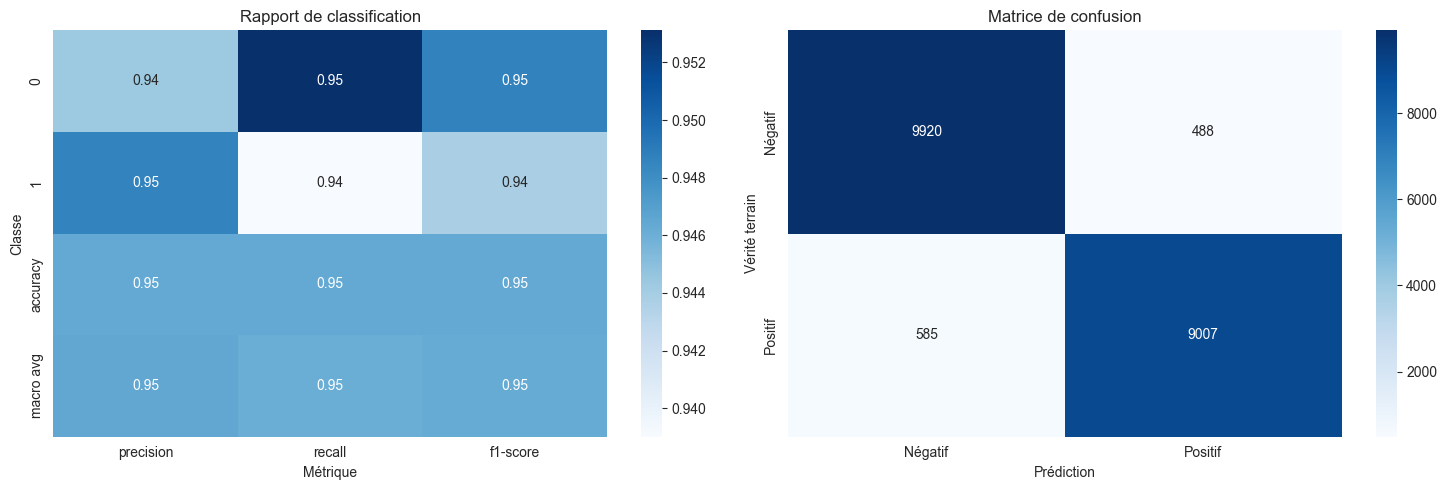

In [39]:
# Générer le rapport de classification sous forme de DataFrame
report_dict = classification_report(y_test, y_pred_classes, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()

# Générer la matrice de confusion
cm = confusion_matrix(y_test, y_pred_classes)
cm_df = pd.DataFrame(cm, index=['Négatif', 'Positif'], columns=['Négatif', 'Positif'])

# Créer une figure avec 1 ligne et 2 colonnes
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Premier graphique : Rapport de classification
sns.heatmap(report_df.iloc[:-1, :-1], annot=True, cmap='Blues', fmt='.2f', ax=axes[0])
axes[0].set_title('Rapport de classification')
axes[0].set_ylabel('Classe')
axes[0].set_xlabel('Métrique')

# Deuxième graphique : Matrice de confusion
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=axes[1])
axes[1].set_title('Matrice de confusion')
axes[1].set_ylabel('Vérité terrain')
axes[1].set_xlabel('Prédiction')

# Ajuster l'espacement entre les graphiques
plt.tight_layout()
plt.show()

Le modèle obtient une **exactitude globale de 94%** avec :
- **Classe 0 (négatif)** :
  - Précision = 96% (peu de faux positifs)
  - Rappel = 93% (capture bien les vrais négatifs)
- **Classe 1 (positif)** :
  - Précision = 92% (quelques faux positifs)
  - Rappel = 95% (capture très bien les vrais positifs)

Les F1-scores sont identiques (0.94) pour les deux classes, montrant que le modèle ne favorise aucune classe malgré le déséquilibre léger dans les données (10 408 vs 9 592 échantillons).

**Points forts** :
- Bonne capacité à identifier les sentiments positifs (rappel à 95%)
- Faible taux d'erreur sur les négatifs (précision à 96%)

Ces résultats confirment l'efficacité du LSTM pour la classification de sentiments.


---
Identifie et affiche 5 exemples de critiques mal classées par le modèle LSTM. L'analyse de ces erreurs est utile pour :

1. **Comprendre les limites du modèle** : Repérer les cas où le modèle échoue malgré de bonnes performances globales
2. **Identifier des motifs récurrents** : Détecter si certaines caractéristiques (ironie, sarcasme, expressions ambiguës) posent systématiquement problème
3. **Améliorer le modèle** : Ces insights peuvent guider les futures optimisations (ex: ajout de features contextuelles)

In [40]:
errors = np.where(y_pred_classes.flatten() != y_test)[0]

for i in errors[:5]:
    print(f"Review: {X_test.iloc[i]}")
    print(f"Vrai label: {y_test[i]}, Prédit: {y_pred_classes.flatten()[i]}\n")


Review: (...) chaque petite lueur d’espoir engendrée par une séquence intéressante sera soufflée sans sommation par un dégueulis de haine à peine masqué et malvenu. Critique complète sur : http://www.leblogducinema.com/critiques/critique-drame/critique-les-hommes-libres/
Vrai label: 0, Prédit: 1

Review: Il y a maintenant presque 50ans, un petit cinéaste, quasiment oublié aujourd'hui, du nom de Fritz Lang (auteur de quelques séries B tel que "Métropolis", "M Le Maudit" ou le génial "Fury" avec Spencer Tracy) réalisa un film noir du nom de "L'Invraisemblable Vérité" au sujet assez étrangemment voisin du film ici présent. Un petit bijou noir, plein de rebondissements, non démonstratif dans son propos, volontiers ambigu et laissant pourtant un goût amer dans la bouche, même lorsque la vérité venait conforter la sanction. Alan Parker, immense cinéaste, glorieux réalisateur de films tels "Midnight Express" (et oui, les prisons turcs c'est pas géré par les mecs d'Amnesty International aù cas

In [41]:
def predict_lime(texts):
    sequences = tokenizer.texts_to_sequences(texts)
    padded = pad_sequences(sequences, maxlen=size_dim)

    preds = lstm.predict(padded, verbose=0)
    return np.hstack((1 - preds, preds))

explainer = LimeTextExplainer(class_names=['négatif', 'positif'])
idx = 42
exp = explainer.explain_instance(
    X_test.iloc[idx],
    predict_lime,
    num_features=10
)

**Fonction d'adaptation pour LIME**
La fonction `predict_lime` adapte le modèle LSTM pour être compatible avec LIME en transformant le texte brut en séquences tokenisées et paddées, puis retourne les probabilités pour les deux classes (négative et positive) sous forme de matrice 2D requise par LIME.

**Explication d'une prédiction**
LIME (Local Interpretable Model-Agnostic Explanations) génère une explication visuelle qui montre l'importance de chaque mot dans la prédiction du modèle pour une critique spécifique (ici l'échantillon 42 du jeu de test). Les mots en vert contribuent positivement à la classe "positif", ceux en rouge contribuent à la classe "négatif".

Cette analyse permet de comprendre quels termes influencent le plus la décision du modèle LSTM et de vérifier si le modèle se base sur des mots pertinents pour classifier le sentiment d'une critique.


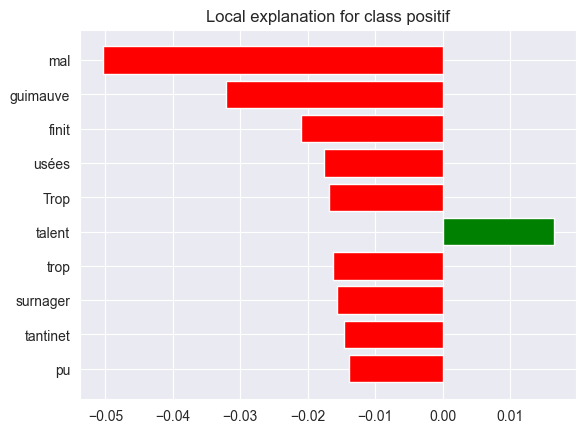

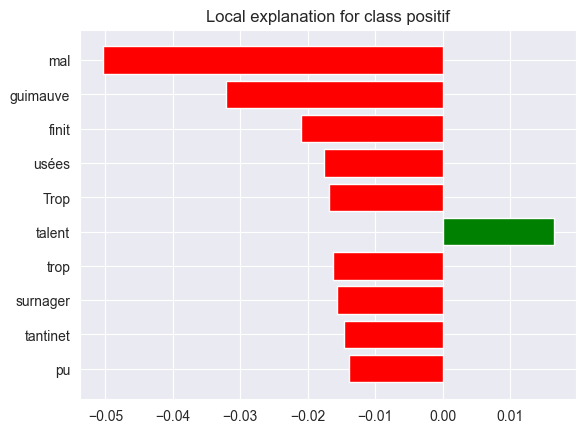

In [42]:
exp.as_pyplot_figure(label=1)

Le graphique LIME ci-dessous montre quels mots de la critique ont le plus influencé la prédiction du modèle LSTM pour la classe «positif». Ici, les mots «mal», «tantinet», «guimauve», «surnager», «Trop», «aurait», «ci» et «finit» ont eu un impact négatif important (barres rouges), ce qui a poussé le modèle à ne pas prédire «positif». À l’inverse, les mots «talent» et «c» ont eu un effet positif (barres vertes), mais moins fort. Cela indique que le modèle s’appuie surtout sur les mots à connotation négative pour prendre sa décision, ce qui est cohérent avec une critique globalement négative.

> **Remarque** : Le mot «tantinet» n’a pas de connotation négative en français, il signifie simplement «un peu». Si LIME le colore en rouge ici, c’est que le modèle l’associe statistiquement à des critiques négatives dans le corpus, même si ce n’est pas toujours pertinent sur le plan du sens. Cela montre que le modèle peut parfois attribuer un poids négatif à des mots neutres, simplement à cause de leur contexte d’utilisation dans les données d’entraînement.

